In [2]:
from torch.utils.data import DataLoader
import cv2
import torch
import torch.nn as nn
import os
import copy
import pandas as pd
from Dataloader import LoadDataset
from PSPNet import PSPNet
import image_show as image_show
import matplotlib.pyplot as plt
import gc
from EarlyStopping import EarlyStopping
gc.collect()
torch.cuda.empty_cache()

In [2]:
model = PSPNet()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if torch.cuda.device_count() > 1:
#   model = nn.DataParallel(model)
# model.to(device)

In [3]:
def train_model(model, loss, optimizer, traindataloader, valdataloader, save_path, num_epochs=1):
  # best_model = copy.deepcopy(model.state_dict())
  # best_loss = 1e5
  train_loss_all = []
  val_loss_all = []
  patience = 17
  early_stopping = EarlyStopping(patience=patience, path=save_path)
  for epoch in range(num_epochs):
    print('Epoch:', epoch)
    train_loss = 0.0
    train_num = 0
    val_loss = 0.0
    val_num = 0

    model.train()
    for images, labels in train_data_loader:
      # images = images.cuda()
      # labels = labels.cuda()

      y_predict = model.forward(images)

      target = torch.argmax(labels, dim=1)
      # target = target.cuda()

      loss = Loss(y_predict, target)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * len(labels)
      train_num += len(labels)

      # pred = torch.argmax(y_predict, dim=1)
      # acc = (pred == target).float().mean()


    train_loss_all.append(train_loss/train_num)
    print('{} Train Loss: {:.4f}'.format(epoch, train_loss_all[-1]))
    # print('{} Train Set Accuracy: {:.4f}'.format(epoch, acc))

    model.eval()
    for val_images, val_labels in val_data_loader:
      # val_images = val_images.cuda()
      # val_labels = val_labels.cuda()
      val_predict = model(val_images)

      target = torch.argmax(val_labels, dim=1)
      # target = target.cuda()

      loss = Loss(val_predict, target)
      val_loss += loss.item() * len(val_labels)
      val_num += len(val_labels)

      # val_pred = torch.argmax(val_predict, dim=1)
      # val_acc = (val_pred == target).float().mean()

    val_loss_all.append(val_loss/ val_num)
    print('{} Val Loss: {:.4f}'.format(epoch, val_loss_all[-1]))
    # print('{} Val Set Accuracy: {:.4f}'.format(epoch, val_acc))


    early_stopping(val_loss_all[-1], model)
    if early_stopping.early_stop:
      print("Early stopping")
      break

    # if val_loss_all[-1] < best_loss:
    #   best_loss = val_loss_all[-1]
    #   best_model = copy.deepcopy(model.state_dict())
  model.load_state_dict(torch.load(save_path))

  train_process = pd.DataFrame(
      data={"epoch":range(num_epochs),
            "train_loss_all":train_loss_all,
            "val_loss_all":val_loss_all})

  return model, train_process

In [5]:
num_workers = 0
num_epochs = 1
batch_size = 1
train_set = LoadDataset(root="CamVid", train_or_val='train')
train_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

val_set = LoadDataset(root="CamVid", train_or_val='val')
val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

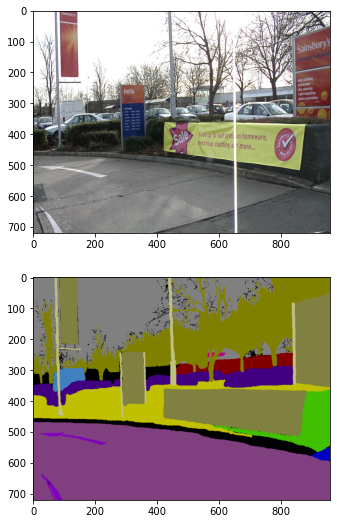

In [17]:
dataiter = iter(train_data_loader)
images, labels = dataiter.next()
image_show.show_image_label(images, labels, batch_size)

In [6]:
# training model!!
learning_rate = 0.001
Loss = nn.CrossEntropyLoss()
save_path = "PSP_checkpoint.pt"
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(),  lr=learning_rate, momentum=0.9, nesterov=True)
# gc.collect()
# torch.cuda.empty_cache()
model, train_process = train_model(model, Loss, optimizer, train_data_loader, val_data_loader, save_path, num_epochs)
torch.save(model.state_dict(), 'PSP_earlystop.pt')
train_process.to_pickle("train_process_nopsp_earlystop.pkl")

Epoch: 0


KeyboardInterrupt: 

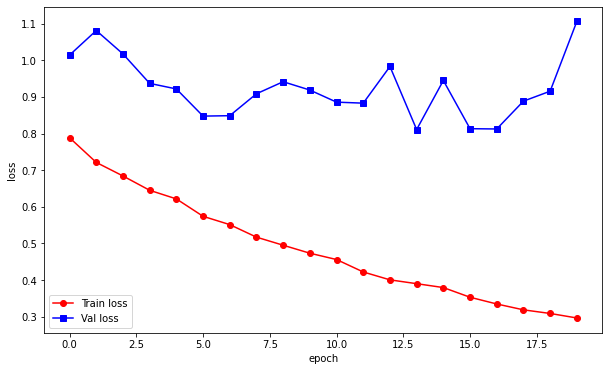

In [13]:
plt.figure(figsize=(10,6))
plt.plot(train_process.epoch, train_process.train_loss_all, 'ro-', label= "Train loss")
plt.plot(train_process.epoch, train_process.val_loss_all, 'bs-', label= "Val loss")
plt.legend()
plt.xlabel('epoch')
plt.ylabel("loss")
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


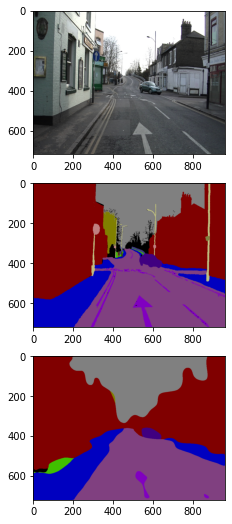

In [6]:
val_data = iter(val_data_loader)
val_images, val_labels = val_data.next()
model.load_state_dict(torch.load("/content/drive/MyDrive/Segmentation/epoch10.pt"))
model.to(device)
model.eval()
val_images = val_images.to(device)
val_labels = val_labels.to(device)
val_predict = model(val_images)

val_predict = val_predict.cpu().data.numpy()
val_images = val_images.cpu().data.numpy()
val_labels = val_labels.cpu().data.numpy()

image_show.show_image_label_predict(val_images, val_labels, val_predict, batch_size)


In [7]:
test_set = LoadDataset(root="/content/drive/MyDrive/Segmentation/CamVid", train_or_val='test')
test_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
import numpy as np

def Average(lst):
    return sum(lst) / len(lst)


def iou(pred, target, IOU_of_all, batch_size=batch_size, n_classes = 32):
  # SMOOTH = 1e8
  # IOUS_batch = []
  # ious_image = []

  for i in range(batch_size):
    predict_image = pred[i]
    predict_image = torch.argmax(predict_image, dim=0)
    predict_image = predict_image.view(-1).numpy()
   

    target_image = target[i]
    target_image = torch.argmax(target_image, dim=0)
    target_image = target_image.view(-1).numpy()

    iou_oneimage = 0.0
    use_classes = 0
    intersection_sum = 0
    union_sum = 0
    for cls in range(n_classes):
      pred_inds = (predict_image == cls)
      target_inds = (target_image == cls)
      intersection = (pred_inds[target_inds]).sum()
      intersection_sum += intersection
      union = pred_inds.sum() + target_inds.sum() - intersection
      union_sum += union

      # if union == 0:
      #   continue
        # print("there is no class {} be predicted".format(cls))
      # else:
      #   iou = float(intersection)/float(union)
        # print("Accuracy of class {} is {}".format(cls,iou))
        # iou_oneimage += iou
        # use_classes += 1
    # iou = iou_oneimage/use_classes
    iou = float(intersection_sum)/float(union_sum)
    IOU_of_all.append(iou)

  return IOU_of_all

In [10]:
gc.collect()
torch.cuda.empty_cache()

model.load_state_dict(torch.load("/content/drive/MyDrive/Segmentation/epoch10.pt"))
model.to(device)
model.eval()
IOU_of_all = []
for i, (test_images, test_labels) in enumerate(test_data_loader):
  test_images = test_images.to(device)
  test_labels = test_labels.to(device)
  test_predict = model(test_images)

  test_predict = test_predict.cpu()
  test_images = test_images.cpu()
  test_labels = test_labels.cpu()
  iou(test_predict, test_labels, IOU_of_all)
  
  if i==20:
    break

mean_IOU = Average(IOU_of_all)
print(mean_IOU)

0.6293070141204421


In [4]:
torch.cuda.device_count()

NameError: name 'torch' is not defined

In [4]:
m = nn.BatchNorm2d(100)
input = torch.rand(20, 100, 1, 1)
output = m(input)
print(output.shape)

torch.Size([20, 100, 1, 1])


In [7]:
import torch.nn.functional as F
# model = nn.Sequential( , # pooling get 2x2, 3x3, 6x6, 11x11
#                     nn.Conv2d(2048, 512, kernel_size=1, bias=False),
#                 nn.BatchNorm2d(512),
#                 nn.ReLU(inplace=True) )


m1 = nn.AdaptiveAvgPool2d(1)
x = torch.rand(1, 2048, 23, 30)
out = [x]

x = m1(x)
# x_size = x.size()
# out.append(F.interpolate(model(x), x_size[2:], mode='bilinear', align_corners=True))
# x = torch.cat(out, 1)

In [8]:
m2 = nn.Conv2d(2048, 512, kernel_size=1, bias=False)
x = m2(x)


NameError: name 'x' is not defined

torch.Size([4, 512, 1, 1])


In [20]:
import torch.nn.functional as F
z = torch.rand(2, 2048, 23, 30)
z_size = z.size()
out = [z]
f = nn.Sequential(
                nn.AdaptiveAvgPool2d(1), # pooling get 2x2, 3x3, 6x6, 11x11
                nn.Conv2d(2048, 512, kernel_size=1, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True)
            )

out.append(F.interpolate(f(z), z_size[2:], mode='bilinear', align_corners=True))
out = torch.cat(out, 1)

In [21]:
print(out.shape)

torch.Size([2, 2560, 23, 30])
